### Introduction


**Problem Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. first make a dataframe by extarcting the descriptions, keywords and id from JDs 
    and combining this with the labels to form the datset. 
2. Pre-processing steps: remove email, replace contractions, punctuations, lemmatize,
    remove stopwords, symbols and extra spaces.
3. dropped duplicate descriptions and kept lables with more than 7(median) count
4. Used LSTM + Attention neural network architecture.
5. Used class weights in order to the balance the Labels
6. Trained unitl overfit

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

### Import Libraries and Data

In [2]:
import json
import glob
import warnings
from fastai.text import *
from fastai.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [3]:
# read Job Departments
label_df = pd.read_csv('data/document_departments.csv') 
label_df.columns = ['id', 'Department']

In [4]:
# read JD
def get_description(path): 
    data = {'description': [], 'id': [], 'job_keywords':[]}
    for filename in glob.glob(path):
        with open(filename, 'r') as json_file:
            jd_data = json.load(json_file)
            data['description'].append(jd_data['jd_information']['description'])
            data['id'].append(int(jd_data['_id']))
            data['job_keywords'].append(' '.join(jd_data['api_data']['job_keywords']))

    return data

jd_df = pd.DataFrame.from_dict(get_description('data/docs/*.json'))

In [5]:
# merge data together and re-index
data = pd.merge(jd_df, label_df, on='id', how='inner').set_index('id')
data.description = data.description+' '+ data.job_keywords
data.drop(['job_keywords'], axis=1, inplace=True)

In [6]:
data.head()

,description,Department
id,,
5922081,Urgent positions for Travel Executive at Saane...,Customer service
6523883,"Dear Candidate,Greetings From Continental Immi...",Sales
6600981,We Have urgent poitions for Ticketing Executiv...,Ticketing
6686185,We Have Urgent positions for Travel booking cu...,Customer service
6726409,Experience in Travel Industry.We have urgent o...,Ticketing


### Clean the text descriptions

In [7]:
import re
import nltk
from collections import Counter 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from multiprocessing import Pool

In [8]:
contarct_dict = {"it's": "it is", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

stop_words = stopwords.words('english')
lmz = WordNetLemmatizer()

# helper functions for preprocessing
def rm_symb_punc(text):
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def email(text):
    pattern = r'\S*@\S*\s?'
    text = re.sub(pattern, '', text)
    return text

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

def replace_contractions(text, contraction_dict=contarct_dict):
    contractions, contractions_re = _get_contractions(contraction_dict)
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(' {2,}', ' ', t)

def rm_stop_lemma(sen):
    sen_new = " ".join([lmz.lemmatize(w) for w in sen if w not in stop_words and (len(w)>2)])
    return sen_new

def pr_proc(text):
    return rm_stop_lemma(rm_useless_spaces(rm_symb_punc(email(replace_contractions(text.lower())))).split(' '))

In [ ]:
pool = Pool(10)
data.description = pool.map(pr_proc, data.description.values)

In [10]:
data.head()

,description,Department
0,urgent position travel executive saanewaal loc...,Customer service
1,dear candidategreetings continental immigratio...,Sales
2,urgent poitions ticketing executive tour trave...,Ticketing
3,urgent position travel booking cum client supp...,Customer service
4,experience travel industrywe urgent opening fo...,Ticketing


### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

In [11]:
print(f'Df Shape: {data.shape}');data.head()

Df Shape: (1162, 2)


,description,Department
0,urgent position travel executive saanewaal loc...,Customer service
1,dear candidategreetings continental immigratio...,Sales
2,urgent poitions ticketing executive tour trave...,Ticketing
3,urgent position travel booking cum client supp...,Customer service
4,experience travel industrywe urgent opening fo...,Ticketing


In [12]:
# check for null values
print(f'Label: number of null values {(data.Department == "").sum()}')
print(f'Text: number of null values {(data.description == "").sum()}')

Label: number of null values 0
Text: number of null values 0


In [13]:
# check for unique values 
print(data.description.nunique())
print(data.Department.nunique())

943
30


**Notes**: Duplicates rows exist in the data 

In [14]:
# drop duplcates
data.drop_duplicates(inplace=True)

In [15]:
data.shape

(955, 2)

In [16]:
dup_descrip = data[data.description.duplicated()].description
dup_descrip

75      immigration consultant sale consultantnbspwe s...
293                             sale business development
641     conducting sale international domestic holiday...
704     cold calling negotiation area mapping prospect...
895     digital marketing seo campaign content writer ...
985     job descriptionnbspsend job like thisproviding...
1068    person indepth understanding key social medial...
1119    exe travel sale consultant travel sale consult...
1125    candidate working seosmo based company candida...
1126    candidate creative designing website template ...
1141    key responsibility role selling online recruit...
1143    job descriptionkey responsibility rolenbsp sel...
Name: description, dtype: object

**Notes**: Job posts with same description but belonging to different department exist, keep one of them to make it multi-class classification    

In [17]:
# drop duplicate descriptions
data = data.loc[data.description.drop_duplicates().index, :]
data.shape

(943, 2)

count     30.000000
mean      31.433333
std       66.816622
min        1.000000
25%        2.000000
50%        7.000000
75%       34.000000
max      319.000000
Name: Department, dtype: float64


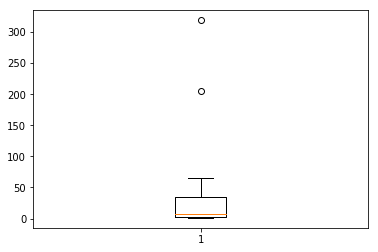

In [18]:
# label distribution
print(data.Department.value_counts().describe())
plt.boxplot(data.Department.value_counts());

**Notes**: Keep labels which appear more than 5 times (median). 

In [19]:
# drop labels with insufficient data
msk = data.Department.value_counts()[data.Department.value_counts() > 7].index
data = data.loc[data.Department.isin(msk), :]
data.reset_index(drop=True, inplace=True)

In [20]:
# number of labels after drop of unimportant ines
data.Department.nunique()

15

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

In [21]:
# encode the labels 
lbl_en = LabelEncoder()
data.Department = lbl_en.fit_transform(data.Department)

In [22]:
data.head()

,description,Department
0,urgent position travel executive saanewaal loc...,3
1,dear candidategreetings continental immigratio...,12
2,urgent poitions ticketing executive tour trave...,14
3,urgent position travel booking cum client supp...,3
4,experience travel industrywe urgent opening fo...,14


In [23]:
# split data into train , validation and test sets
train, test = train_test_split(data.loc[:, ['Department', 'description']], test_size=0.15, random_state=0, shuffle=True, stratify=data.Department) 

In [24]:
# prep data for the model
md = TextClasDataBunch.from_df(path='.', train_df=train, valid_df=test, bs=128)
md.show_batch()

text,target
xxbos arsenius skill capital hiring client relation xxunk delhi mumbai xxunk lac panbspindustry corporate amp business xxunk customer relationship management crm amp xxunk xxunk managing aspect assigned client account include limited client retention contract negotiation implementation business xxunk sale product service financials budget billing payment profitability business planning review establishing relationship key decision maker multiple region staff development business continuance escalation operational xxunk duty responsibility establish amp maintain relationship responsible,14
xxbos primary role tsmtso prospect new clientsfranchisetravel agent networking reference cold callingadvertising mean generating interest potential client must plan persuasive approach andpitches convince potential client business company must develop rapport new client andset target sale provide support continually improve relationship also required grow andretain existing account presenting new solution service clientstsmtso work mid senior levelmanagement marketing technical staff heshe may manage activity others responsible developing businessfor company strategic planning key,12
xxbos dear candidatenbsphope wellnbspwe came across profile portal amp wanted share role younbsplocation ndash bangalorenbspclientfounded clientis worldwide leader vacation exchange provider travel service business consumer unique breadth scope accommodation choice type location clientoffers global community three million member quality vacation experience resort worldwide weekforweek pointsbased exchange network growth partner clientdelivers customized integrated resultsdriven solution meet need exceed expectation affiliate consumer worldwide clientis division clientglobal vacation network global leader nonhotel leisure,2
xxbos walk copy xxunk interglobe xxunk business xxunk ground xxunk road pune ndash near xxunk xxunk stand xxunk xxunk xxunk monday xxunk person xxunk xxunk number xxunk technology looking process associate handle sale customer care process end end airline operation position based pune report team leader xxunk bpo position responsible handling customer care related issue reservation web site support bulk booking notification xxunk credit card verification queue management email management,14
xxbos apply interested work new xxunk responsible selling holiday package domestic amp xxunk tour executive must good knowledge indian international destination detail responsibility domestic xxunk booking receiving xxunk providing client best possible routing destination competitive fare available market designing itinerary hotel booking amp costing contracting hotel managing supplier effectively communicating order get timely confirmation candidate well versed operational aspect booking capable web query walkin client query make professional accurate cost,14


## Model

In [25]:
# laod pre-trained Embeddings
def get_embs(file_path):
    word_embeddings = {}
    f = open(file_path, encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings

vectors = get_embs('glove/glove.6B.300d.txt')

In [26]:
# helper func to load only required embeddings
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [27]:
class BnLinLy(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.lin = nn.Linear(ni, no)
        self.bn = nn.BatchNorm1d(no)
        
    def forward(self, x):
        return self.bn(F.relu(self.lin(x)))
    
class ResnetLy(BnLinLy):
    def forward(self, x): return x + super().forward(x)

In [28]:
# Model
class AttenLSTM(nn.Module):
    def __init__(self, vocab_ln,nh, nc, vecs, itos,layers,emb_sz=300):
        super().__init__()
        self.nh, self.nc = nh, nc
        self.emb = create_emb(vecs, itos, emb_sz)
        self.enc = nn.LSTM(emb_sz, nh, dropout=0.5) 
        #self.lin = ResnetLy(nh, nh)
        self.lin1 = nn.ModuleList([BnLinLy(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.lin2 = nn.ModuleList([ResnetLy(layers[i+1], layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(nh//2, nc)
    
    def attention_net(self, lstm_output, final_state):
        '''
        hidden.size() = (batch_size, hidden_size)
        attn_weights.size() = (batch_size, num_seq)
        soft_attn_weights.size() = (batch_size, num_seq)
        new_hidden_state.size() = (batch_size, hidden_size)
        '''
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return new_hidden_state
 
    def forward(self, inp):
        inp = inp.permute(1,0)
        sl, bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb(inp)
        outp, h = self.enc(emb, h)
        outp = outp.permute(1,0,2)
        attn_output = self.attention_net(outp, h[0])
        for l1, l2 in zip(self.lin1, self.lin2):
            attn_output = l2(l1(attn_output))
        out = self.out(attn_output)
        return out
    
    def initHidden(self, bs): 
        return torch.zeros(1, bs, self.nh).to('cuda'), torch.zeros(1, bs, self.nh).to('cuda')
    
    def res_layer(self):
        return 

In [29]:
vocab_sz = len(md.train_dl.vocab.itos)
# initialize model
model = AttenLSTM(vocab_sz, nh=150, nc=15, vecs=vectors, itos=md.train_dl.vocab.itos, layers=[150, 75]).cuda()

1042 ['xxmaj', 'xxup', 'xxrep', 'xxwrep', 'nbsp']


In [30]:
# initailize weights for the classes (class imbalance)
class_weights = class_weight.compute_class_weight('balanced',
                                                 data.Department.unique(),
                                                 data.Department)

class_weights = torch.FloatTensor(class_weights).cuda()

In [31]:
learn = Learner(md, model, loss_func= nn.CrossEntropyLoss(weight=class_weights), metrics=[accuracy])

In [32]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.683739,2.637541,0.345588,00:44
1,2.425799,2.121215,0.360294,00:34
2,2.063377,1.369869,0.514706,00:37
3,1.794401,1.505891,0.367647,00:38
4,1.546192,1.237597,0.404412,00:36
5,1.372566,1.098870,0.470588,00:36


In [33]:
learn.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.723185,1.027082,0.522059,00:38
1,0.668784,1.000522,0.536765,00:43


In [34]:
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')

In [39]:
# get single pred
description = data.description.values[30]
#description = input()
tokens = [md.train_dl.vocab.stoi[w] for w in tokenizer.process_text(description, tok)]
pred = to_np(F.log_softmax(model(torch.LongTensor(tokens).view(1, -1).cuda()), dim=1).max(1)[1])

print(f'Description: \n{description}\n\nClass: {lbl_en.inverse_transform(pred)[0]}')

Description: 
arsenius skill capital urgent requirement corporate salespositionnbspcorporate salesdesignationassistant managermanagersr managercompensation lac lac palocationmumbaijob rolenbspthis job profile requires candidate build strong client relation manage overall functionality improve corporate sale amp operation profile requires customer centric professional acquire new account manage end end travel planning corporatenbspcandidate profilegraduates mba preferable tourism year minimum experience given role handling corporate marketing sale candidate handling corporate marketing sale telecom finance retail also considerednbspjob responsibilitiesinterested candidate may share call kind regardsangee nandi arsenius skill capital sale marketing sale corporate sale business development business business sale sale channel sale

Class: Sales


**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. Model Accuracy is ~ 52%.
2. The DataSet is very imbalanced, oversampig of minority classes may be helpful, or generation using knn.
3. Other fields like skill, location, etc.,may be extarcted from the job description which may be helpful in the model.